# Imports

First, we'll import the necessary libraries.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import datetime
import io
import zipfile
import rasterio
from rasterio.plot import show
import sklearn
from sklearn.neighbors import KernelDensity
import numpy as np

import collections

# in response to an error importing collections, I used this: https://stackoverflow.com/questions/72032032/importerror-cannot-import-name-iterable-from-collections-in-python

from collections.abc import Iterable

collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import mapclassify

Next, we'll query the City of Philadelphia data via the ArcGIS REST API using the `requests` library. We'll also use the `json` library to parse the response.

Finally, we'll use the `geopandas` library to create a geodataframe from the response.

We have three different datasets to import from the City's ArcGIS server. These are:

### 1. Vacant Land

In [2]:
# Define the URL for the Vacant_Indicators_Land feature service
land_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Land/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Land API request
land_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_Land API request
land_response = requests.get(land_url, params=land_params)

# Check if the Vacant_Indicators_Land request was successful
if land_response.status_code == 200:
    # Convert the Vacant_Indicators_Land JSON data to a geopandas geodataframe; convert to CRS 3857
    land_data = land_response.json()

    # convert the JSON data to a pandas dataframe
    land_df = pd.DataFrame(land_data['features'])

    # separate the attributes column into one column per attribute
    land_df = pd.concat([land_df.drop(['attributes'], axis=1), land_df['attributes'].apply(pd.Series)], axis=1)

else:
    print('Vacant_Indicators_Land Request failed with status code:', land_response.status_code)


# make the `geometry` column a shapely geometry object
land_df['geometry'] = land_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))


 # convert the pandas dataframe to a geopandas geodataframe
land_gdf = gpd.GeoDataFrame(land_df, geometry='geometry', crs='EPSG:3857')

land_gdf.to_crs(epsg=2272, inplace=True)

### 2. Vacant Buildings

In [3]:
# Define the URL for the Vacant_Indicators_Bldg feature service
bldg_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Bldg/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Bldg API request
bldg_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_Bldg API request
bldg_response = requests.get(bldg_url, params=bldg_params)

# Check if the Vacant_Indicators_Bldg request was successful
if bldg_response.status_code == 200:
    # Convert the Vacant_Indicators_Bldg JSON data to a geopandas geodataframe; convert to CRS 3857
    bldg_data = bldg_response.json()

    # convert the JSON data to a pandas dataframe
    bldg_df = pd.DataFrame(bldg_data['features'])

    # separate the attributes column into one column per attribute
    bldg_df = pd.concat([bldg_df.drop(['attributes'], axis=1), bldg_df['attributes'].apply(pd.Series)], axis=1)

else:
    print('Vacant_Indicators_bldg Request failed with status code:', bldg_response.status_code)


# make the `geometry` column a shapely geometry object
bldg_df['geometry'] = bldg_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))


 # convert the pandas dataframe to a geopandas geodataframe
bldg_gdf = gpd.GeoDataFrame(bldg_df, geometry='geometry', crs='EPSG:3857')

bldg_gdf.to_crs(epsg=2272, inplace=True)

### Now, combine the two datasets in preparation for string cleaning.

In [4]:
columns = ['geometry', 'ADDRESS', 'BLDG_DESC',
       'OPA_ID','COUNCILDISTRICT',
       'ZIPCODE','OWNER1', 'OWNER2']

# reduce gdfs to only the columns we want
land_gdf = land_gdf[columns]

bldg_gdf = bldg_gdf[columns]

land_gdf['type'] = 'Lot'

bldg_gdf['type'] = 'Building'

In [5]:
# bind the two geodataframes together using pandas.concat
full_gdf = pd.concat([land_gdf, bldg_gdf], axis=0)

### Now we'll apply string cleaning to the OWNER1 and OWNER2 columns to identify public vs. private ownership.

In [6]:
public_owners = ['PHILADELPHIA LAND BANK',
                'PHILADELPHIA HOUSING AUTH',
                'CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA',
                'DEPT OF PUBLC PROP; CITY OF PHILA',
                'DEPT OF PUBLIC PROP; CITY OF PHILA',
                'DEPT PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILA',
                'PHILA REDEVELOPMENT AUTH',
                'PHILADELPHIA LAND INVESTM',
                'REDEVELOPMENT AUTHORITY O',
                'PHILADELPHIA REDEVELOPMEN',
                'PHILA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHOR',
                'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING',
                'PHILA REDEVELOPMENT AUTHO',
                'DEPT OF PUB PROP; CITY OF PHILA',
                'PHILA HOUSING DEV CORP',
                'DEP OF PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY',
                'COMMONWEALTH OF PA',
                'COMMONWEALTH OF PENNA',
                'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                'DEPT PUBLIC PROP R E DIV; CITY OF PHILA',
                'PUBLIC PROP DIV; CITY OF PHILA',
                'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                'REAL ESTATE DIV; CITY OF PHILA',
                'REAL ESTATE DIVISION; CITY OF PHILA',
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING'
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA REDEVELOPMENT AUTH',
                'PHILADELPHIA HOUSING AUTHORITY',
                'PHILADELPHIA LAND BANK',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA HOUSING AUTHORITY',
                'CITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHORITY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'COMMONWEALTH OF PENNSYLVANIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PENNDOT'
]

# return unique public_owners
public_owners = list(set(public_owners))

In [7]:
# create a new column that combines the OWNER1 and OWNER2 columns according to the following rules:
# if OWNER1 is not null and OWNER2 is null, then the new column is OWNER1
# if OWNER1 is null and OWNER2 is not null, then the new column is OWNER2
# if OWNER2 starts with a preposition, then the new column is OWNER1 + OWNER2 separated by a space
# if OWNER2 does not start with a preposition, then the new column is OWNER2 + OWNER1 separated by a se


# define a function to check if a string starts with a preposition
def starts_with_preposition(string):
    prepositions = ['a', 'an', 'and', 'as', 'at', 'but', 'by', 'for', 'from', 'in', 'into', 'nor', 'of', 'on', 'or', 'so', 'the', 'to', 'up', 'yet']
    if string.split(' ')[0].lower() in prepositions:
        return True
    else:
        return False
    
# define a function to combine the OWNER1 and OWNER2 columns
def combine_owners(row):
    if pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return None
    elif pd.isnull(row['OWNER1']) and not pd.isnull(row['OWNER2']):
        return row['OWNER2']
    elif not pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return row['OWNER1']
    elif starts_with_preposition(row['OWNER2']):
        return row['OWNER1'] + ' ' + row['OWNER2']
    else:
        return row['OWNER2'] + '; ' + row['OWNER1']
    
# apply the combine_owners function to the full_gdf dataframe
full_gdf['OWNER'] = full_gdf.apply(combine_owners, axis=1)

# if OWNER is 'PHILADELPHIA HOUSING AUTH' or 'PHILA HOUSING AUTHORITY', replace with 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILADELPHIA HOUSING AUTH', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING AUTHORITY', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'

# redevelopment authority typos
redev_owner_variations = ['REDEVELOPMENT AUTHORITY OF PHILA', 'PHILA REDEVELOPMENT AUTH',
'REDEVELOPMENT AUTHORITY O', 'PHILADELPHIA REDEVELOPMEN',
'PHILA REDEVELOPMENT AUTHO', 'REDEVELOPMENT AUTHORITY',
'REDEVELOPMENT AUTH']

for var in redev_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA'

# department of public property typos
dpp_owner_variations = ['DEPT OF PUBLIC PROPERTY', 'DEPT OF PUBLIC PROPERT', 'DEPT OF PUBLC PROP; CITY OF PHILA',
                        'DEPT OF PUBLIC PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROPERTY; CITY OF PHILA', 'DEPT PUB PROP; CITY OF PHILA',
                        'DEPT OF PUB PROP; CITY OF PHILA', 'DEP OF PUB PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                        'DEPT PUBLIC PROP R E DIV; CITY OF PHILA', 'PUBLIC PROP DIV; CITY OF PHILA', 'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                        'REAL ESTATE DIV; CITY OF PHILA', 'REAL ESTATE DIVISION; CITY OF PHILA']

for var in dpp_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY'

# HUD
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'

# commonwealth of pennsylvania
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PENNA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'

# phdc
full_gdf.loc[full_gdf['OWNER'] == 'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING DEV CORP', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'

# PennDOT
full_gdf.loc[full_gdf['OWNER'] == 'DEPARTMENT OF TRANSPORTAT; COMMONWEALTH OF PENNSYLVA', 'OWNER'] = 'PENNDOT'

# city of Philadelphia
full_gdf.loc[full_gdf['OWNER'] == 'CITY OF PHILADELPHIA', 'OWNER'] = 'CITY OF PHILA'

# create a new column called 'public_owner' that is True if the OWNER column is in the public_owners list
full_gdf['public_owner'] = full_gdf['OWNER'].isin(public_owners)

# drop the OWNER1 and OWNER2 columns
full_gdf = full_gdf.drop(['OWNER1', 'OWNER2'], axis=1)

In [8]:
# randomly sample ten rows from the full_gdf dataframe
full_gdf.sample(10)

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner
1110,"POLYGON ((2694472.865 257356.396, 2694469.455 ...",1813 W ERIE AVE,VAC LAND RES < ACRE,131061900,8,19140,Lot,3637 REALTY LLC,False
525,"POLYGON ((2700537.723 262872.070, 2700537.147 ...",4821 N MARSHALL ST,ROW 2 STY MASONRY,491191600,8,19120,Building,ROSARIO JACKELINE P; GARCIA GERMAN G,False
1467,"POLYGON ((2686463.987 239434.331, 2686350.867 ...",406 N 32ND ST,VAC LAND RES < ACRE,241213800,3,19104,Lot,VRESILOVIC KELLY FRENCH; VRESILOVIC EDWARD J JR,False
1111,"POLYGON ((2696824.374 223350.476, 2696816.256 ...",314 PORTER ST,VAC LAND RES < ACRE,392217700,1,19148,Lot,BARKOWITZ EDWARD J,False
15,"POLYGON ((2693333.093 250775.579, 2693266.942 ...",2533 N 19TH ST,VAC LAND RES < ACRE,162081000,5,19132,Lot,PHILADELPHIA LAND INVESTM,True
32,"POLYGON ((2696417.559 226064.805, 2696415.117 ...",1913 S 5TH ST,VAC LAND COMM. < ACRE,392272300,1,19148,Lot,XIONG DAFEN,False
209,"POLYGON ((2700164.086 248824.671, 2700162.164 ...",2344 N 3RD ST,VAC LAND RES < ACRE,191185000,7,19133,Lot,VALDEZ LUZ DEL ALBA SANCHEZ; VALDEZ FRANKELLY,False
1062,"POLYGON ((2676140.277 243453.148, 2676138.463 ...",5125 KERSHAW ST,SEMI DET 2 STY MASONRY,442148600,3,19131,Building,HAYNES HENRY,False
236,"POLYGON ((2715594.506 260553.768, 2715594.012 ...",1612-14 FOULKROD ST,APT 2-4 UNTS 3STY MASONR,232170600,7,19124,Building,ADIGHIBE UMACHI CHINYERE,False
1111,"POLYGON ((2696119.982 230162.033, 2696115.046 ...",641 WASHINGTON AVE,ROW CONV/APT 3STY MASONRY,021145700,1,19147,Building,QUACH LEE,False


### 3. PHS Community Landcare Parcels

Now we can import the PHS Community LandCare parcels and spatially join them to our full_gdf, which contains all of the vacant parcels in the city (both lots and buildings).

In [9]:
# Define the URL for the Vacant_Indicators_phs_landcare feature service
phs_landcare_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PHS_CommunityLandcare/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_phs_landcare API request
phs_landcare_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_phs_landcare API request
phs_landcare_response = requests.get(phs_landcare_url, params=phs_landcare_params)

# Check if the Vacant_Indicators_phs_landcare request was successful
if phs_landcare_response.status_code == 200:
    # Convert the Vacant_Indicators_phs_landcare JSON data to a geopandas geodataframe
    phs_landcare_data = phs_landcare_response.json()

    # convert the JSON data to a pandas dataframe
    phs_landcare_df = pd.DataFrame(phs_landcare_data['features'])

    # separate the attributes column into one column per attribute
    phs_landcare_df = pd.concat([phs_landcare_df.drop(['attributes'], axis=1), phs_landcare_df['attributes'].apply(pd.Series)], axis=1)

    # make the `geometry` column a shapely geometry object
    phs_landcare_df['geometry'] = phs_landcare_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

    # convert the pandas dataframe to a geopandas geodataframe
    phs_landcare_gdf = gpd.GeoDataFrame(phs_landcare_df, geometry='geometry', crs='EPSG:2272')

else:
    print('PHS_CommunityLandcare Request failed with status code:', phs_landcare_response.status_code)


phs_columns = ['geometry', 'ADDRESS', 'COMM_PARTN']

phs_landcare_gdf = phs_landcare_gdf[phs_columns]

In [10]:
# spatially join phs_landcare_gdf to full_gdf
joined_gdf = gpd.sjoin(full_gdf, phs_landcare_gdf, how='left', op='intersects')

# drop the index_right column and the ADDRESS_right column
joined_gdf = joined_gdf.drop(['index_right', 'ADDRESS_right'], axis=1)

# rename the ADDRESS_left column to ADDRESS
joined_gdf = joined_gdf.rename(columns={'ADDRESS_left': 'ADDRESS'})

joined_gdf['COMM_PARTN'] = joined_gdf['COMM_PARTN'].fillna('None', inplace=True)

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Now we need to import two more datasets from the City's Carto database (SQL).

### 1. L&I Complaints

In [11]:
# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
complaints_sql_query = "SELECT address, service_request_id, subject, status, service_name, service_code, lat, lon FROM public_cases_fc WHERE requested_datetime >= '{}'".format(one_year_ago)

# Make the GET request
complaints_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": complaints_sql_query})

# Get the data
complaints_data = complaints_response.json()["rows"]

# convert complaints_data to a pandas dataframe
complaints_df = pd.DataFrame(complaints_data)

# Convert the data to a geopandas dataframe
complaints_gdf = gpd.GeoDataFrame(complaints_df, geometry=gpd.points_from_xy(complaints_df.lon, complaints_df.lat), crs='EPSG:2272')

# drop the lat and lon columns
complaints_gdf.drop(['lat', 'lon'], axis=1, inplace=True)

# filter for only Status = 'Open'
complaints_gdf = complaints_gdf[complaints_gdf['status'] == 'Open']

# collapse complaints_gdf by address and concatenate the violationcodetitle values into a list with a semicolon separator
complaints_gdf = complaints_gdf.groupby('address')['service_name'].apply(lambda x: '; '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'li_complaints'
complaints_gdf.rename(columns={'service_name': 'li_complaints'}, inplace=True)


### 2. L&I Code Violations

In [12]:
# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
violations_sql_query = "SELECT parcel_id_num, casenumber, casecreateddate, casetype, casestatus, violationnumber, violationcodetitle, violationstatus, opa_account_num, address, opa_owner, geocode_x, geocode_y FROM violations WHERE violationdate >= '{}'".format(one_year_ago)

# Make the GET request
violations_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": violations_sql_query})

# Get the data
violations_data = violations_response.json()["rows"]

# convert violations_data to a pandas dataframe
violations_df = pd.DataFrame(violations_data)

# Convert the data to a geopandas dataframe
violations_gdf = gpd.GeoDataFrame(violations_df, geometry=gpd.points_from_xy(violations_df.geocode_x, violations_df.geocode_y), crs='EPSG:2272')

# drop the lat and lon columns
violations_gdf.drop(['geocode_x', 'geocode_y'], axis=1, inplace=True)

# filter for only cases where the casestatus is 'IN VIOLATION' or 'UNDER INVESTIGATION'
violations_gdf = violations_gdf[(violations_gdf['violationstatus'] == 'OPEN')]

# collapse violations_gdf by address and concatenate the violationcodetitle values into a list with a semicolon separator
violations_gdf = violations_gdf.groupby('opa_account_num')['violationcodetitle'].apply(lambda x: '; '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'li_violations'
violations_gdf.rename(columns={'violationcodetitle': 'li_code_violations'}, inplace=True)

In [13]:
# left join the complaints_gdf to the joined_gdf on address
joined_gdf = joined_gdf.merge(complaints_gdf, how='left', left_on='ADDRESS', right_on='address')

# left join the violations_gdf to the joined_gdf on opa_account_num
joined_gdf = joined_gdf.merge(violations_gdf, how='left', left_on='OPA_ID', right_on='opa_account_num')

# drop the address and opa_account_num columns
joined_gdf.drop(['address', 'opa_account_num'], axis=1, inplace=True)

### Next, we'll add a centroids column to the joined_gdf in order to make it easier to cleanly join neighborhoods, RCOs, tree canopy, and guncrime data.

Joining by points rather than polygons makes it far less likely that a point straddles two polygons, which make the join ambiguous and potentially incorrect.

In [14]:
# add a column for centroids geometry to use for joins and to extrct raster values
joined_gdf['centroid'] = joined_gdf['geometry'].centroid

# create a geodata of polygon geoms and opa_id
poly_gdf = joined_gdf[['OPA_ID', 'geometry']]

# drop the 'geometry' column from joined_gdf
joined_gdf.drop(['geometry'], axis=1, inplace=True)

# set the 'centroid' column as the geometry column
joined_gdf.set_geometry('centroid', inplace=True)

### Import Philadelphia's Neighborhoods from Azavea

In [15]:
hoods_url = 'https://github.com/azavea/geo-data/raw/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.zip'

hoods_response = requests.get(hoods_url)

with io.BytesIO(hoods_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
hoods = gpd.read_file("path/to/destination/folder/Neighborhoods_Philadelphia.shp")

hoods = hoods.to_crs(epsg=2272)

In [16]:
joined_gdf = gpd.sjoin(joined_gdf, hoods, how='left', op='intersects')

joined_gdf = joined_gdf.drop(['index_right', 'NAME', 'LISTNAME', 'Shape_Leng', 'Shape_Area'], axis=1)

joined_gdf.rename(columns={'MAPNAME': 'neighborhood'}, inplace=True)

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


### Import RCOs from the City

In [17]:
# Define the URL for the RCOs feature service
rcos_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Zoning_RCO/FeatureServer/0/query'

# Define the parameters for the RCOs API request
rcos_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the RCOs API request
rcos_response = requests.get(rcos_url, params=rcos_params)

# Check if the RCOs request was successful
if rcos_response.status_code == 200:
    # Convert the RCOs JSON data to a geopandas geodataframe; convert to CRS 3857
    rcos_data = rcos_response.json()

    # convert the JSON data to a pandas dataframe
    rcos_df = pd.DataFrame(rcos_data['features'])

    # separate the attributes column into one column per attribute
    rcos_df = pd.concat([rcos_df.drop(['attributes'], axis=1), rcos_df['attributes'].apply(pd.Series)], axis=1)

else:
    print('RCOs Request failed with status code:', rcos_response.status_code)


# make the `geometry` column a shapely geometry object
rcos_df['geometry'] = rcos_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))


 # convert the pandas dataframe to a geopandas geodataframe
rcos_gdf = gpd.GeoDataFrame(rcos_df, geometry='geometry', crs='EPSG:3857')

rcos_gdf.to_crs(epsg=2272, inplace=True)

rcos_cols = ['geometry', 'ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS',
       'ORG_TYPE', 'PREFFERED_CONTACT_METHOD',
       'PRIMARY_NAME', 'PRIMARY_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE',
       'EXPIRATIONYEAR']

# convert primary_phone and expirationyear to strings
rcos_gdf['PRIMARY_PHONE'] = rcos_gdf['PRIMARY_PHONE'].astype(str)
rcos_gdf['EXPIRATIONYEAR'] = rcos_gdf['EXPIRATIONYEAR'].astype(str)

In [18]:
rco_aggregate_cols = ['ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE']

rcos_gdf["rco_info"] = rcos_gdf[rco_aggregate_cols].agg("; ".join, axis=1)

In [19]:
rcos_final_cols = ['geometry', 'rco_info']

rcos_gdf = rcos_gdf[rcos_final_cols]

### Now we can join the RCOs to the joined_gdf.

In [20]:
# spatially join rcos_gdf to joined_gdf
w_rcos_gdf = gpd.sjoin(joined_gdf, rcos_gdf, how='left', op='within')

# drop the index_right column
w_rcos_gdf = w_rcos_gdf.drop(['index_right'], axis=1)

# change MAPNAME to neighborhood

w_rcos_gdf.rename(columns={'rco_info': 'rco_info'}, inplace=True)

# remove duplicates by OPA_ID
w_rcos_gdf = w_rcos_gdf.drop_duplicates(subset='OPA_ID')

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
# plot w_rcos_gdf
w_rcos_gdf.shape

(3969, 14)

In [22]:
# make OPA_ID a string
w_rcos_gdf['OPA_ID'] = w_rcos_gdf['OPA_ID'].astype(str)

# collapse w_rcos_gdf by opa_id and concatenate the rco_info values into a list with a | separator
rcos_by_opa_id_gdf = w_rcos_gdf.groupby('OPA_ID')['rco_info'].apply(lambda x: '| '.join([str(val) for val in x if val is not None])).reset_index()

# rename the column to 'relevant_rcos'
rcos_by_opa_id_gdf.rename(columns={'rco_info': 'relevant_rcos'}, inplace=True)

In [23]:
rcos_by_opa_id_gdf.shape

(3969, 2)

In [24]:
# left join the rcos_by_opa_id_gdf to the joined_gdf on opa_id
joined_gdf = joined_gdf.merge(rcos_by_opa_id_gdf, how='left', left_on='OPA_ID', right_on='OPA_ID')

# drop duplicate rows
joined_gdf = joined_gdf.drop_duplicates(subset='OPA_ID')


In [25]:
joined_gdf.shape

(3969, 14)

In [26]:
joined_gdf.sample(5)

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,centroid,neighborhood,relevant_rcos
364,2207 N ORIANNA ST,VAC LAND RES < ACRE,191191100,7,19133,Lot,JACOB BARBARA; JACOB JOSEPH,False,None,NaN,NaN,POINT (2699969.540 248013.282),West Kensington,Zulu Nation RCO; 2045 N Lawrence Street\r\nPhi...
3585,2220 S BEECHWOOD ST,ROW 2 STY MASONRY,482181100,2,19145,Building,BRAUDE RICHARD,False,None,Dangerous Building Complaint; Maintenance Comp...,"EXTERIOR STRUCTURE WINDOWS, SKYLIGHTS DOOR FRA...",POINT (2688447.819 225741.536),West Passyunk,Concerned Citizens of Point Breeze; Concerned ...
331,960 FARSON ST,VAC LAND RES < ACRE,442244300,3,19131,Lot,KOLE AND COMPANY LLC,False,None,NaN,NaN,POINT (2677108.061 242009.135),Mill Creek,Parkside Association; Parkside Evans Recreatio...
2490,5833 MONTROSE ST,ROW 2 STY MASONRY,033073500,3,19143,Building,BLANKS CLARENCE N,False,None,Maintenance Complaint; Maintenance Complaint; ...,UNSAFE STRUCTURE; ROOF DEFICIENCIES; INTERIOR ...,POINT (2671996.133 234154.587),Cobbs Creek,Progressive Communities CDC; 413 South 60th St...
3613,3851 N FAIRHILL ST,ROW 2 STY MASONRY,432252700,7,19140,Building,ALEGARBES ALBERTO; FLORO ISABELITA A,False,None,Maintenance Complaint,NaN,POINT (2700243.251 257409.531),Hunting Park,Nueva Esperanza Housing and Economic Developme...


### Finally, tree canopy data.

In [27]:
tree_url = 'https://national-tes-data-share.s3.amazonaws.com/national_tes_share/pa.zip.zip'

tree_response = requests.get(tree_url)

with io.BytesIO(tree_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
pa = gpd.read_file("path/to/destination/folder/pa.shp")

pa = pa.to_crs(epsg=2272)

phl = pa[pa['county'] == 'Philadelphia County']

tree_cols = ['tc_gap', 'geometry']

phl = phl[tree_cols]

phl.rename(columns={'tc_gap': 'tree_canopy_gap'}, inplace=True)

phl.head()

,tree_canopy_gap,geometry
5395,0.216832,"POLYGON ((2698038.313 234970.868, 2697586.173 ..."
5396,0.196093,"POLYGON ((2699640.691 237442.051, 2699638.100 ..."
5397,0.297005,"POLYGON ((2696855.043 237339.498, 2696827.290 ..."
5398,0.346134,"POLYGON ((2693798.320 238055.129, 2693725.464 ..."
5399,0.097603,"POLYGON ((2689575.081 237146.348, 2689561.703 ..."


In [28]:
# spatially join phl to joined_gdf
joined_gdf = gpd.sjoin(joined_gdf, phl, how='left', op='intersects')

joined_gdf = joined_gdf.drop(['index_right'], axis=1)

# drop duplicate opa_ids
joined_gdf = joined_gdf.drop_duplicates(subset='OPA_ID')

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [29]:
joined_gdf.shape

(3969, 15)

In [30]:
joined_gdf.head()

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,centroid,neighborhood,relevant_rcos,tree_canopy_gap
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,Abandoned Vehicle,NaN,POINT (2687670.347 256881.319),Allegheny West,"East Falls Community Council; PO Box 12672, 19...",0.230223
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2675594.486 242078.492),Haddington,Parkside Association; Parkside Evans Recreatio...,0.104381
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2694579.519 249996.821),Stanton,Uptown Entertainment and Development Corporati...,0.165151
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,NaN,POINT (2699241.653 246723.548),West Kensington,Zulu Nation RCO; 2045 N Lawrence Street\r\nPhi...,0.199069
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN,POINT (2695050.897 251708.887),Stanton,"Tioga United, Inc.; 1539 W. Venango Street \r\...",0.327281


<AxesSubplot: >

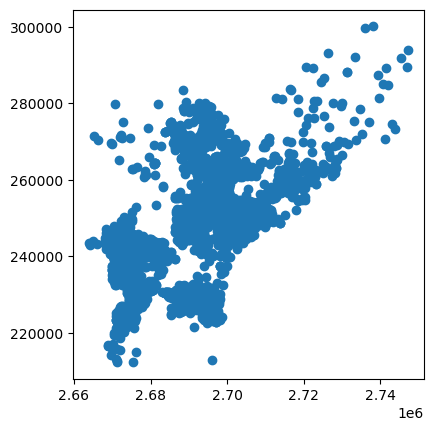

In [31]:
# plot the joined_gdf
joined_gdf.plot()


# Gun Crimes

For our gun crime kernel density estimate, we have two steps:

### 1. Import gun crime data from the City's Carto database (SQL):

In [32]:
# Modify the SQL query
guncrime_sql_query = "SELECT text_general_code, dispatch_date, point_x, point_y FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}' AND text_general_code IN ('Aggravated Assault Firearm', 'Robbery Firearm')".format(one_year_ago)

# Make the GET request
guncrime_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": guncrime_sql_query})

# Get the data
guncrime_data = guncrime_response.json()["rows"]

# convert guncrime_data to a pandas dataframe
guncrime_df = pd.DataFrame(guncrime_data)

# Convert the data to a geopandas dataframe
guncrime_gdf = gpd.GeoDataFrame(guncrime_df, geometry=gpd.points_from_xy(guncrime_df.point_x, guncrime_df.point_y), crs='EPSG:4326')

# drop the lat and lon columns
guncrime_gdf.drop(['point_x', 'point_y'], axis=1, inplace=True)

# convert the geometry column to a CRS 2272
guncrime_gdf.to_crs(epsg=2272, inplace=True)

# drop null geometry values
guncrime_gdf = guncrime_gdf[guncrime_gdf['geometry'].notnull()]

c:\Users\Nissim\anaconda3\envs\vac_props_guncrime_dash\Lib\site-packages\geopandas\geoseries.py:751: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [33]:
guncrime_gdf.head()

,text_general_code,dispatch_date,geometry
0,Robbery Firearm,2022-08-19,POINT (2726676.221 264105.934)
1,Robbery Firearm,2022-09-11,POINT (2697059.540 255757.300)
2,Aggravated Assault Firearm,2022-09-16,POINT (2674924.522 243211.406)
3,Aggravated Assault Firearm,2022-09-06,POINT (2694009.941 248712.979)
4,Aggravated Assault Firearm,2022-10-11,POINT (2674606.387 241816.289)


### 2. Create a kernel density estimate from the gun crime data:

In [34]:
# Get X and Y coordinates of well points
x_sk = guncrime_gdf["geometry"].x
y_sk = guncrime_gdf["geometry"].y

# drop null values
x_sk = x_sk.dropna()
y_sk = y_sk.dropna()

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = guncrime_gdf.total_bounds

In [35]:
# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()]).T

# Create 2-D array of the coordinate values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk]).T

In [36]:
# Get kernel density estimator (can change parameters as desired)
kde_sk = KernelDensity(bandwidth = 5280, metric = 'euclidean', kernel = 'gaussian', algorithm = 'auto')

# Fit kernel density estimator to wells coordinates
kde_sk.fit(Xtrain_sk)

# Evaluate the estimator on coordinate pairs
Z_sk = np.exp(kde_sk.score_samples(positions_sk))

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

In [37]:
today = datetime.datetime.today().strftime('%Y_%m_%d')


def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = rasterio.Affine.translation(min_x - xres / 2, min_y - yres / 2) * rasterio.Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z_export.shape[0],
            width = Z_export.shape[1],
            count = 1,
            dtype = Z_export.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z_export, 1)

# Export raster
kde_filename = f"C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast_{today}.tif"
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                  min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                  proj = 2272, filename = kde_filename)

In [38]:
src = rasterio.open(kde_filename)

<AxesSubplot: >

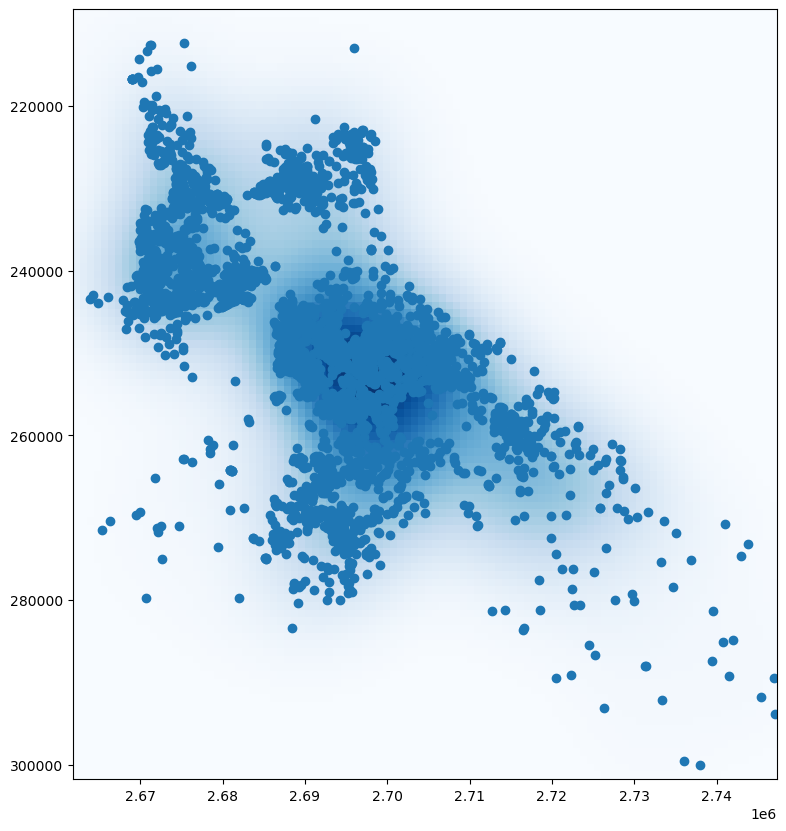

In [39]:
from rasterio.plot import show

fix, ax = plt.subplots(figsize=(10, 10))

extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='Blues')

joined_gdf.plot(ax=ax)

In [40]:
coord_list = [(x,y) for x,y in zip(joined_gdf['centroid'].x, joined_gdf['centroid'].y)]

joined_gdf['guncrime_density'] = [x for x in src.sample(coord_list)]

# convert 'guncrime_density' column to float
joined_gdf['guncrime_density'] = joined_gdf['guncrime_density'].astype(float)

In [41]:
joined_gdf.head()

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,centroid,neighborhood,relevant_rcos,tree_canopy_gap,guncrime_density
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,Abandoned Vehicle,NaN,POINT (2687670.347 256881.319),Allegheny West,"East Falls Community Council; PO Box 12672, 19...",0.230223,3.863540e-10
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2675594.486 242078.492),Haddington,Parkside Association; Parkside Evans Recreatio...,0.104381,4.676726e-10
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2694579.519 249996.821),Stanton,Uptown Entertainment and Development Corporati...,0.165151,8.706567e-10
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,NaN,POINT (2699241.653 246723.548),West Kensington,Zulu Nation RCO; 2045 N Lawrence Street\r\nPhi...,0.199069,7.364297e-10
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN,POINT (2695050.897 251708.887),Stanton,"Tioga United, Inc.; 1539 W. Venango Street \r\...",0.327281,8.856570e-10


<AxesSubplot: >

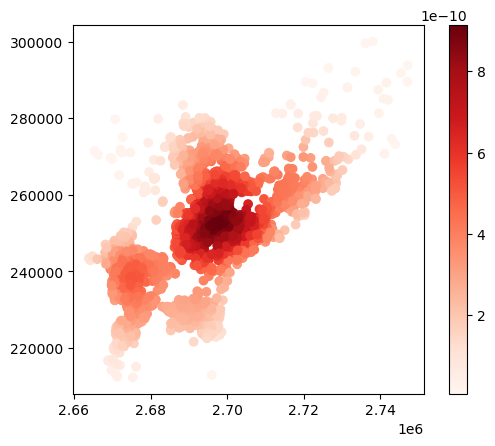

In [42]:
# plot the centroids with the guncrime density as the color
joined_gdf.plot(column='guncrime_density', cmap='Reds', legend=True)

Reclassify data into percentiles.

In [43]:
guncrime_classifier = mapclassify.Percentiles(joined_gdf['guncrime_density'], pct=[10, 50, 90, 99, 100])

joined_gdf['guncrime_density'] = joined_gdf[['guncrime_density']].apply(guncrime_classifier)

joined_gdf['guncrime_density'] = joined_gdf['guncrime_density'].replace([0, 1, 2, 3, 4], ['Bottom 10%', 'Bottom 50%', 'Top 50%', 'Top 10%', 'Top 1%'])

In [44]:
tree_classifier = mapclassify.Percentiles(joined_gdf['tree_canopy_gap'], pct=[10, 50, 90, 99, 100])

joined_gdf['tree_canopy_gap'] = joined_gdf[['tree_canopy_gap']].apply(tree_classifier)

joined_gdf['tree_canopy_gap'] = joined_gdf['tree_canopy_gap'].replace([0, 1, 2, 3, 4], ['Bottom 10%', 'Bottom 50%', 'Top 50%', 'Top 10%', 'Top 1%'])

In [45]:
joined_gdf.head()

,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations,centroid,neighborhood,relevant_rcos,tree_canopy_gap,guncrime_density
0,3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,Abandoned Vehicle,NaN,POINT (2687670.347 256881.319),Allegheny West,"East Falls Community Council; PO Box 12672, 19...",Top 50%,Bottom 50%
1,633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2675594.486 242078.492),Haddington,Parkside Association; Parkside Evans Recreatio...,Bottom 50%,Bottom 50%
2,2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN,POINT (2694579.519 249996.821),Stanton,Uptown Entertainment and Development Corporati...,Bottom 50%,Top 10%
3,437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,NaN,POINT (2699241.653 246723.548),West Kensington,Zulu Nation RCO; 2045 N Lawrence Street\r\nPhi...,Top 50%,Top 50%
4,2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN,POINT (2695050.897 251708.887),Stanton,"Tioga United, Inc.; 1539 W. Venango Street \r\...",Top 10%,Top 10%


In [48]:
# now join the poly_gdf back to the joined_gdf on the opa_id column
joined_gdf = joined_gdf.join(poly_gdf.set_index('OPA_ID'), on='OPA_ID')

# drop the 'centroids' column
joined_gdf = joined_gdf.drop(columns=['centroid'])

# make 'geometry' the geometry column
joined_gdf = joined_gdf.set_geometry('geometry')

In [49]:
# set all column names to lowercase
joined_gdf.columns = map(str.lower, joined_gdf.columns)

In [51]:
joined_gdf.sample(10)

,address,bldg_desc,opa_id,councildistrict,zipcode,type,owner,public_owner,comm_partn,li_complaints,li_code_violations,neighborhood,relevant_rcos,tree_canopy_gap,guncrime_density,geometry
1651,623 N CAMAC ST,VAC LAND RES < ACRE,141178900,5,19123,Lot,METROPOLY LLC,False,None,NaN,NaN,West Poplar,14th Ward Democratic Executive Committee; 1117...,Top 50%,Bottom 50%,"POLYGON ((2695025.755 240430.543, 2695037.061 ..."
878,819 W BIRCH ST,VAC LAND RES < ACRE,372398700,5,19133,Lot,BCM SECOND INVESTMENT LLC,False,None,NaN,NaN,Hartranft,Asociacion Puertorriquenos En Marcha (APM); 60...,Bottom 10%,Top 1%,"POLYGON ((2698292.959 252353.432, 2698286.438 ..."
3904,6616 CHEW AVE,ROW 2 STY MASONRY,221254600,8,19119,Building,TOWER PROPERTY LLC,False,None,Maintenance Complaint,DOOR AND WINDOW VACANT; EXTERIOR STRUCTURE ROO...,East Mount Airy,"East Mt. Airy Neighbors; 7301 Germantown Ave.,...",Bottom 10%,Bottom 10%,"POLYGON ((2687976.391 273128.854, 2687937.199 ..."
3887,1325 W SELTZER ST,ROW 2 STY MASONRY,372325300,5,19132,Building,OUR DEEDS LLC,False,None,NaN,NaN,Hartranft,Asociacion Puertorriquenos En Marcha (APM); 60...,Top 50%,Top 10%,"POLYGON ((2696082.984 251778.746, 2696076.498 ..."
2055,2415 W MONTGOMERY AVE,VAC LAND RES < ACRE,322214500,5,19121,Lot,ROBINSON ADOPHNEY,False,None,NaN,NaN,North Central,"32nd Democratic Ward; 2112 N Woodstock St, Phi...",Bottom 50%,Top 50%,"POLYGON ((2690229.701 247058.709, 2690218.742 ..."
3660,6635 GERMANTOWN AVE,ROW W-OFF/STR 2STY MASONR,871528200,8,19119,Building,BENNETT CLINTON,False,None,Maintenance Complaint; Maintenance Complaint,VACANT STRUCTURE & LAND; EXTERIOR AREA SANITAT...,East Mount Airy,"East Mt. Airy Neighbors; 7301 Germantown Ave.,...",Bottom 50%,Bottom 10%,"POLYGON ((2686699.647 271696.275, 2686648.645 ..."
545,5213 W GIRARD AVE,VAC LAND RES < ACRE,442090500,3,19131,Lot,DAWKINS WILLIAM C,False,None,NaN,NaN,Carroll Park,Parkside Association; Parkside Evans Recreatio...,Top 50%,Bottom 50%,"POLYGON ((2675724.377 242569.480, 2675708.177 ..."
228,244 N LAWRENCE ST,VAC LAND COMM. < ACRE,885675780,1,19106,Lot,AUTHORITY; DELAWARE RIVER PORT,False,None,NaN,NaN,Old City,5th Ward Republican RCO; 1500 Walnut Street Su...,Top 50%,Bottom 50%,"POLYGON ((2698033.064 237411.856, 2698061.050 ..."
1731,2171 E WILLIAM ST,VAC LAND RES < ACRE,252078000,1,19134,Lot,FRANCES; ONNIE PRIMUS,False,None,NaN,NaN,Richmond,Port Richmond On Patrol & Civic Association (P...,Bottom 50%,Top 50%,"POLYGON ((2706444.192 249261.885, 2706388.606 ..."
1277,1438 N CARLISLE ST,VAC LAND RES < ACRE,471169310,5,19121,Lot,CITY OF PHILA,True,None,Maintenance Complaint; Maintenance Complaint,NaN,North Central,Temple Area Property Association (TAPA); 1639 ...,Bottom 50%,Top 50%,"POLYGON ((2694389.486 244715.636, 2694388.196 ..."


<AxesSubplot: >

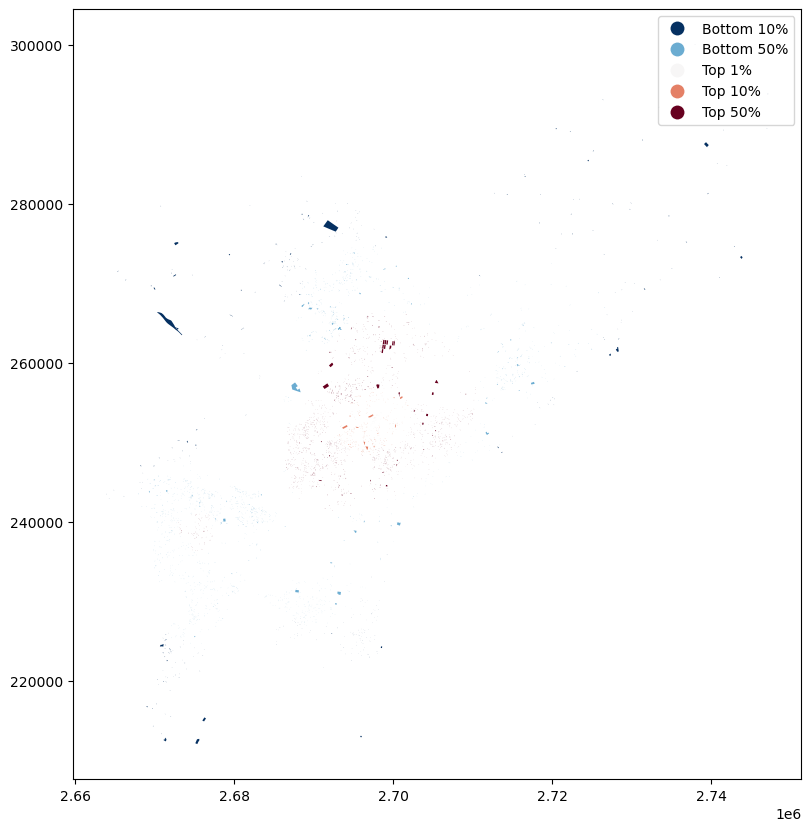

In [59]:
joined_gdf.plot(column='guncrime_density', cmap=plt.cm.RdBu_r, legend=True, figsize=(10,10))
